In [1]:
# Required Imports
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from sklearn.metrics import f1_score
import numpy as np
import cv2
from torchsummary import summary
#from torchinfo import summary  # Model summary
from torchvision.models import VGG16_Weights
import requests
import zipfile
from tqdm import tqdm  # Progress bara
import matplotlib.pyplot as plt

In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [13]:
# Define Model Architecture

trained_model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
trained_model.classifier = nn.Sequential(
    nn.Linear(trained_model.classifier[0].in_features, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 8),
    # nn.Softmax(dim=1)
)
trained_model.to(device)



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [15]:
# Load The saved model and define Inferance Loop
# Load the Haar cascade face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load the trained model
# trained_model = base_model
trained_model.load_state_dict(torch.load('/data/leuven/361/vsc36144/maibi_cv/Saved_Model/model-affectnet-original001.pth'))
trained_model.to(device)
trained_model.eval()

# Define a function to detect and recognize facial expressions
input_shape = (96, 96)
dataset_path_val = '/data/leuven/361/vsc36144/maibi_cv/AffectNet_Splitted/val'
dataset_classes = datasets.ImageFolder(dataset_path_val).classes
def detect_expression(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        face = image[y:y+h, x:x+w]
        face = cv2.resize(face, input_shape)
        face = transforms.ToTensor()(face).unsqueeze(0)
        face = face.to(device)

        # Predict the emotion class
        with torch.no_grad():
            outputs = trained_model(face)
            _, predicted = torch.max(outputs, 1)
            emotion_class = dataset_classes[predicted.item()]

        # Draw bounding box and label on the image
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(image, emotion_class, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    return image


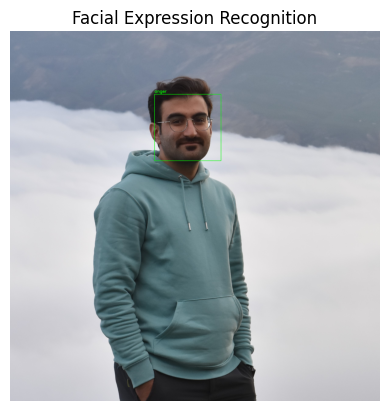

In [16]:
# Load an input image to check
input_image = cv2.imread('Ahmad.JPG')

# Convert BGR to RGB for displaying correctly with matplotlib
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

# Detect and recognize facial expressions
output_image = detect_expression(input_image)

# Display the output image using matplotlib
plt.imshow(output_image)
plt.axis('off')
plt.title('Facial Expression Recognition')
plt.show()

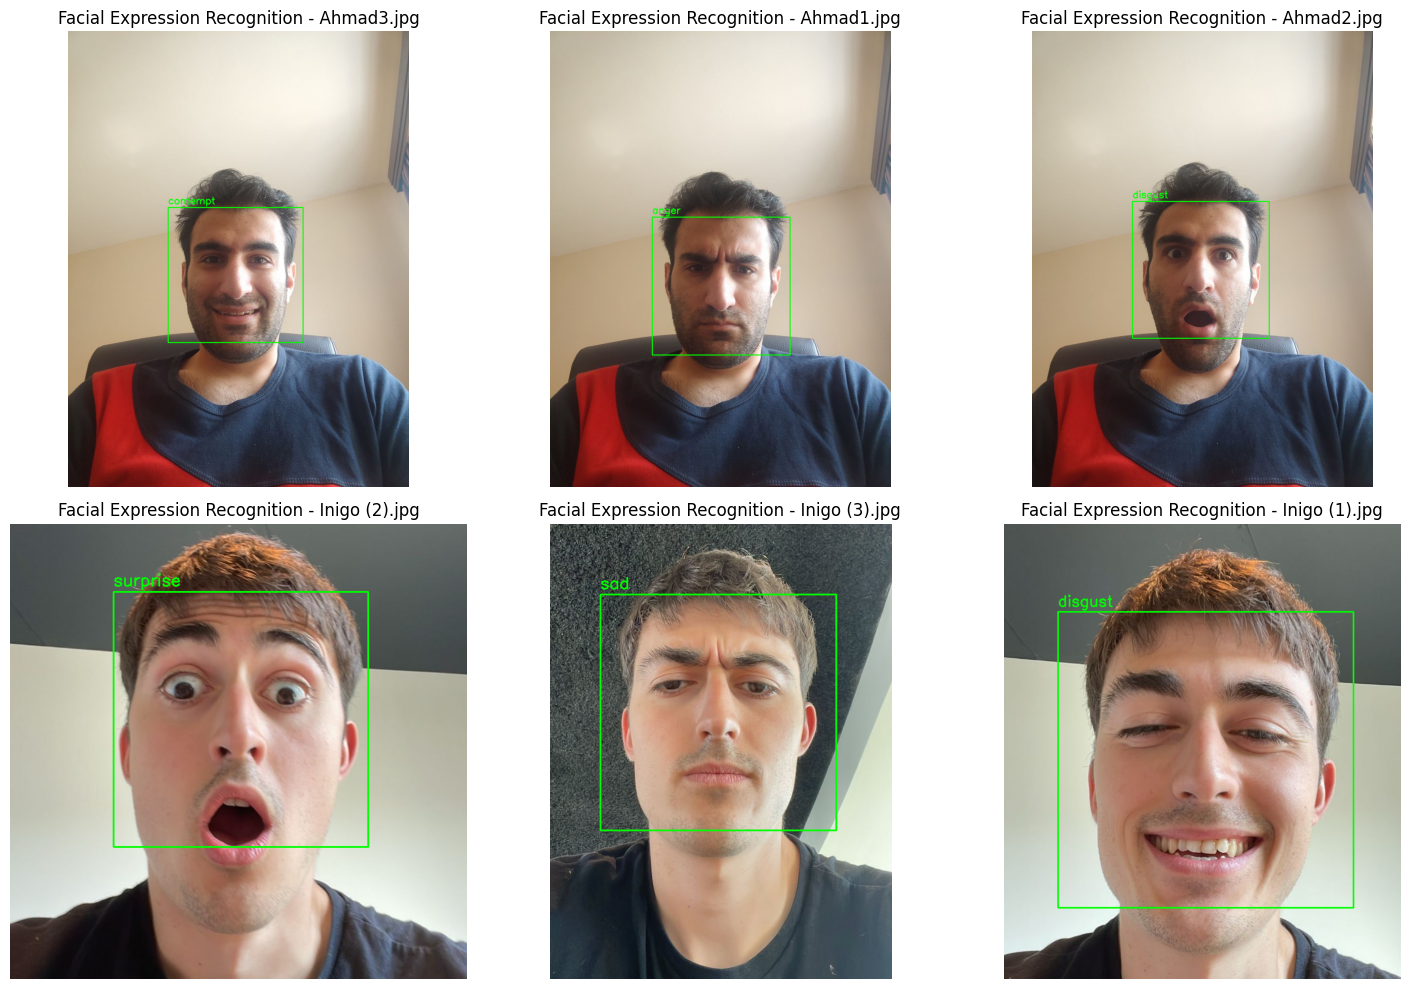

In [17]:
# Make Inferance of the full pipeline on images inside Our_Images Folder
# Path to the folder containing images
folder_path = '/data/leuven/361/vsc36144/maibi_cv/Our_Images'

# List to store all images and filenames
images = []
filenames = []

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
        # Construct full file path
        file_path = os.path.join(folder_path, filename)
        
        # Load an input image
        input_image = cv2.imread(file_path)

        # Convert BGR to RGB for displaying correctly with matplotlib
        input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

        # Detect and recognize facial expressions
        output_image = detect_expression(input_image)
        
        # Store the output image and filename
        images.append(output_image)
        filenames.append(filename)

# Number of images
num_images = len(images)

# Number of images per row
images_per_row = 3

# Create a figure for plotting
fig, axs = plt.subplots((num_images + images_per_row - 1) // images_per_row, images_per_row, figsize=(15, 5 * ((num_images + images_per_row - 1) // images_per_row)))

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Plot each image
for i in range(num_images):
    axs[i].imshow(images[i])
    axs[i].axis('off')
    axs[i].set_title(f'Facial Expression Recognition - {filenames[i]}')

# Hide any remaining empty subplots
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

# Show the plot
plt.tight_layout()
plt.show()